In [1]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

raw_data_dir = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/raw")

mESC_data_dir = raw_data_dir / "mESC_lower_max_peak_dist"
macrophage_data_dir = raw_data_dir / "macrophage"
k562_data_dir = raw_data_dir / "K562"


## mESC

In [ ]:
unique_peaks = set()
unique_genes = set()
for item in mESC_data_dir.iterdir():
    if item.is_dir():
        print(f"mESC subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith("scATAC_seq_raw.parquet"):
                print(f"  - File: {file.name}")
                parquet_file = pq.ParquetFile(file)
                unique_peaks.update(parquet_file.schema.names)
            if file.name.endswith("scRNA_seq_raw.parquet"):
                print(f"  - File: {file.name}")
                parquet_file = pq.ParquetFile(file)
                unique_genes.update(parquet_file.schema.names)

print()
print(f"Total unique genes in mESC RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in mESC ATAC-seq data: {len(unique_peaks)}")

## Macrophage

In [ ]:
unique_peaks = set()
unique_genes = set()
unique_cells = set()
for item in macrophage_data_dir.iterdir():
    if item.is_dir():
        print(f"macrophage subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith(f"matched_filtered_ATAC_rawcounts_{item.name}.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_peaks.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())
            if file.name.endswith(f"matched_filtered_RNA_rawcounts_{item.name}.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_genes.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())

print()
print(f"Total unique genes in macrophage RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in macrophage ATAC-seq data: {len(unique_peaks)}")
print(f"Total unique cells in macrophage ATAC-seq data: {len(unique_cells)}")

macrophage subdir: buffer_3
  - File: matched_filtered_ATAC_rawcounts_buffer_3.csv
  - File: matched_filtered_RNA_rawcounts_buffer_3.csv
macrophage subdir: buffer_2
  - File: matched_filtered_RNA_rawcounts_buffer_2.csv
  - File: matched_filtered_ATAC_rawcounts_buffer_2.csv
macrophage subdir: buffer_1
  - File: matched_filtered_ATAC_rawcounts_buffer_1.csv
  - File: matched_filtered_RNA_rawcounts_buffer_1.csv
macrophage subdir: buffer_4
  - File: matched_filtered_ATAC_rawcounts_buffer_4.csv
  - File: matched_filtered_RNA_rawcounts_buffer_4.csv

Total unique genes in macrophage RNA-seq data: 10063
Total unique peaks in macrophage ATAC-seq data: 271348
Total unique cells in macrophage ATAC-seq data: 1635


## K562

In [ ]:
unique_peaks = set()
unique_genes = set()
unique_cells = set()
for item in k562_data_dir.iterdir():
    if item.is_dir():
        print(f"K562 subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith(f"K562_human_filtered_ATAC.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_peaks.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())
            if file.name.endswith(f"K562_human_filtered_RNA.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_genes.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())

print()
print(f"Total unique cells in K562 ATAC-seq data: {len(unique_cells)}")
print(f"Total unique genes in K562 RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in K562 ATAC-seq data: {len(unique_peaks)}")


K562 subdir: sample_1
  - File: K562_human_filtered_RNA.csv
  - File: K562_human_filtered_ATAC.csv

Total unique genes in K562 RNA-seq data: 10012
Total unique peaks in K562 ATAC-seq data: 177439
Total unique cells in K562 ATAC-seq data: 412


## Best Experiment Results

2 Hops, 40k distance scale factor, higher max peak distance

In [8]:
mESC_exp_name = "mESC_slow_decay_long_range_two_hop"
macrophage_exp_name = "Macrophage_two_hops_slow_decay_long_range_small_batch"
k562_exp_name = "K562_two_hops_slow_decay_long_range"

experiment_dir = Path(f"/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments")

def open_auc_data_files(exp_name: str, model_num: int = 1):
    exp_path = experiment_dir / exp_name / "chr19" / f"model_training_{model_num:03d}"
    per_tf_df = pd.read_csv(exp_path / "per_tf_auroc_auprc_detailed.csv", header=0, index_col=None)
    per_gt_df = pd.read_csv(exp_path / "per_gt_method_aucs_detailed.csv", header=0, index_col=None)
    return per_tf_df, per_gt_df

k562_per_tf_df, k562_per_gt_df = open_auc_data_files(k562_exp_name)
mESC_per_tf_df, mESC_per_gt_df = open_auc_data_files(mESC_exp_name)
macrophage_per_tf_df, macrophage_per_gt_df = open_auc_data_files(macrophage_exp_name)



In [3]:
def calculate_mean_auroc_for_method(per_gt_df: pd.DataFrame, method_name: str) -> float:
    return per_gt_df[per_gt_df["name"] == method_name]["auroc"].mean()

def calculate_mean_per_tf_auroc(per_tf_df: pd.DataFrame, method_name: str) -> float:
    # Select only rows for the specified method
    per_tf_mean_by_method = per_tf_df[per_tf_df["method"] == method_name]
    
    # Calculate the mean AUROC per ground truth for all TFs
    per_tf_mean_score = per_tf_mean_by_method.groupby("tf")["auroc"].mean().reset_index()
    
    # Calculate the mean AUROC across all ground truths
    per_tf_mean_by_gt = per_tf_mean_score["auroc"].mean()
    
    return per_tf_mean_by_gt

method_list = ["Gradient Attribution", "TF Knockout"]
for method in method_list:
    k562_mean_per_tf_auroc = calculate_mean_per_tf_auroc(k562_per_tf_df, method)
    macrophage_mean_per_tf_auroc = calculate_mean_per_tf_auroc(macrophage_per_tf_df, method)
    mESC_mean_per_tf_auroc = calculate_mean_per_tf_auroc(mESC_per_tf_df, method)
    
    k562_mean_auroc = calculate_mean_auroc_for_method(k562_per_gt_df, method)
    macrophage_mean_auroc = calculate_mean_auroc_for_method(macrophage_per_gt_df, method)
    mESC_mean_auroc = calculate_mean_auroc_for_method(mESC_per_gt_df, method)
    
    print(method)
    print(f"  - Mean AUROC:")
    print(f"    - mESC: {mESC_mean_auroc:.3f}")
    print(f"    - Macrophage: {macrophage_mean_auroc:.3f}")
    print(f"    - K562: {k562_mean_auroc:.3f}")
    print() 
    
    print(f"  - Mean per-TF AUROC:")
    print(f"    - mESC: {mESC_mean_per_tf_auroc:.3f}")
    print(f"    - Macrophage: {macrophage_mean_per_tf_auroc:.3f}")
    print(f"    - K562: {k562_mean_per_tf_auroc:.3f}")
    print()


Gradient Attribution
  - Mean AUROC:
    - mESC: 0.540
    - Macrophage: 0.551
    - K562: 0.538

  - Mean per-TF AUROC:
    - mESC: 0.581
    - Macrophage: 0.563
    - K562: 0.564

TF Knockout
  - Mean AUROC:
    - mESC: 0.532
    - Macrophage: 0.552
    - K562: 0.525

  - Mean per-TF AUROC:
    - mESC: 0.562
    - Macrophage: 0.557
    - K562: 0.556



In [4]:
import matplotlib.pyplot as plt
import numpy as np
def plot_all_results_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("name")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["name"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["name"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.0, 1.0))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

In [5]:
def per_tf_method_one(per_tf_metrics: pd.DataFrame):
    # ===== Method 1: Mean of Each TF per Ground Truth =====
    method_gt_avg = (
        per_tf_metrics
        .groupby(['method', 'gt_name'], as_index=False)
        .agg(
            auroc=('auroc', 'mean'),
            auprc=('auprc', 'mean'),
            n_tfs=('tf', 'nunique'),
        )
    )

    method_gt_avg.rename(columns={'method': 'name'}, inplace=True)

    # Plot the boxplots and save data
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(method_gt_avg, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

def per_tf_method_two(per_tf_metrics: pd.DataFrame):
    per_tf_for_plot = per_tf_metrics[['method', 'auroc', 'auprc']].copy()
    per_tf_for_plot = per_tf_for_plot.rename(columns={'method': 'name'})
    

    # Plot the boxplots and save data like above methods
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_for_plot, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

def per_tf_method_three(per_tf_metrics: pd.DataFrame):
    # ===== Method 3: Calculate the Mean TF AUROC/AUPRC Across All GTs =====
    per_tf_mean_across_gt = (
        per_tf_metrics
        .groupby(['method', 'tf'], as_index=False)
        .agg(
            auroc=('auroc', 'mean'),
            auprc=('auprc', 'mean'),
            n_gt=('gt_name', 'nunique'),
        )
    )

    per_tf_mean_across_gt.rename(columns={'method': 'name'}, inplace=True)

        #Plot the boxplots and save data like above methods
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_mean_across_gt, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

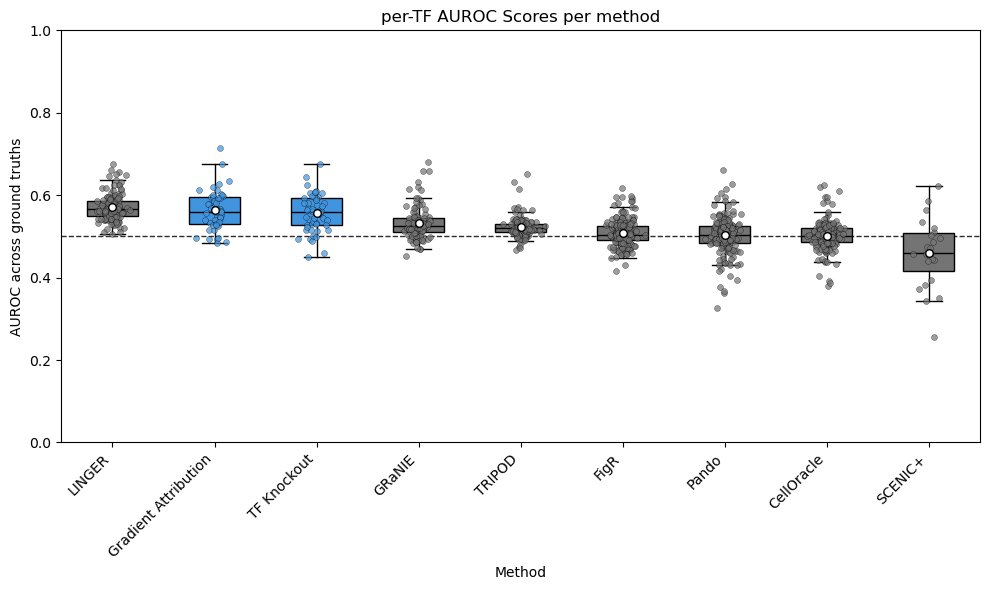

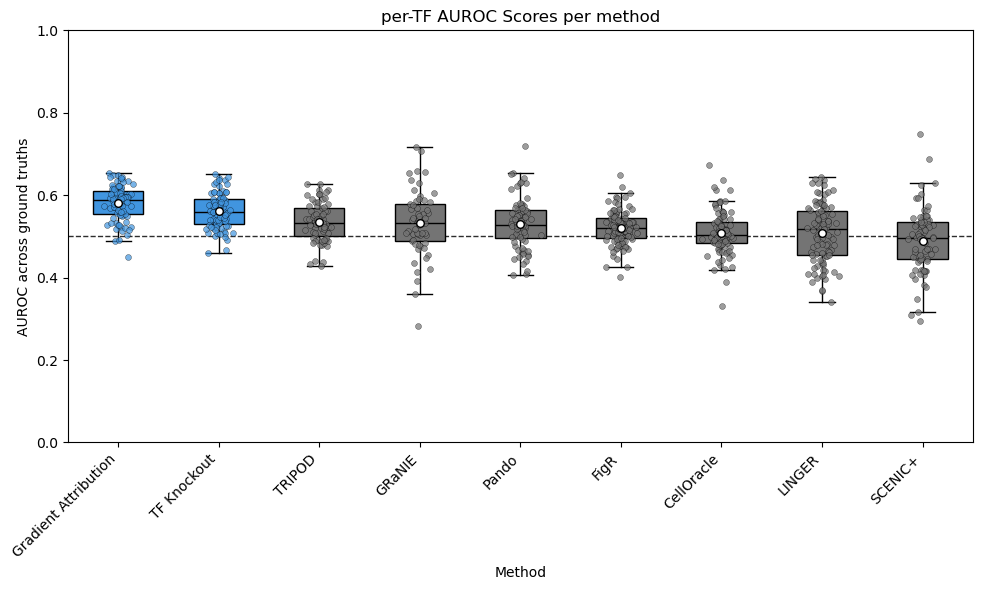

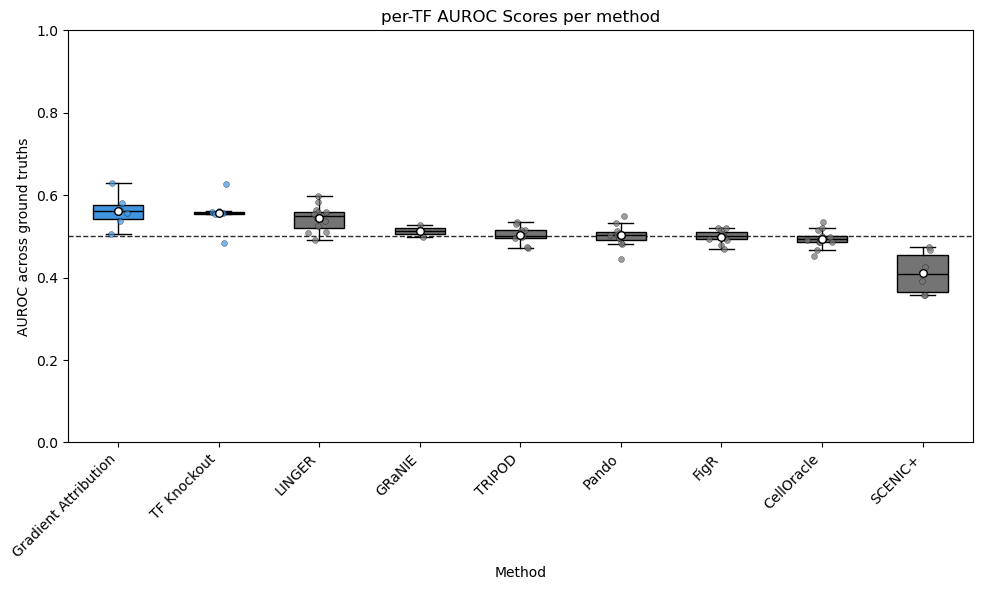

In [6]:
# Calculate and plot per-TF method rankings using different approaches
per_tf_method_three(k562_per_tf_df)
per_tf_method_three(mESC_per_tf_df)
per_tf_method_three(macrophage_per_tf_df)

## Testing refactored model results

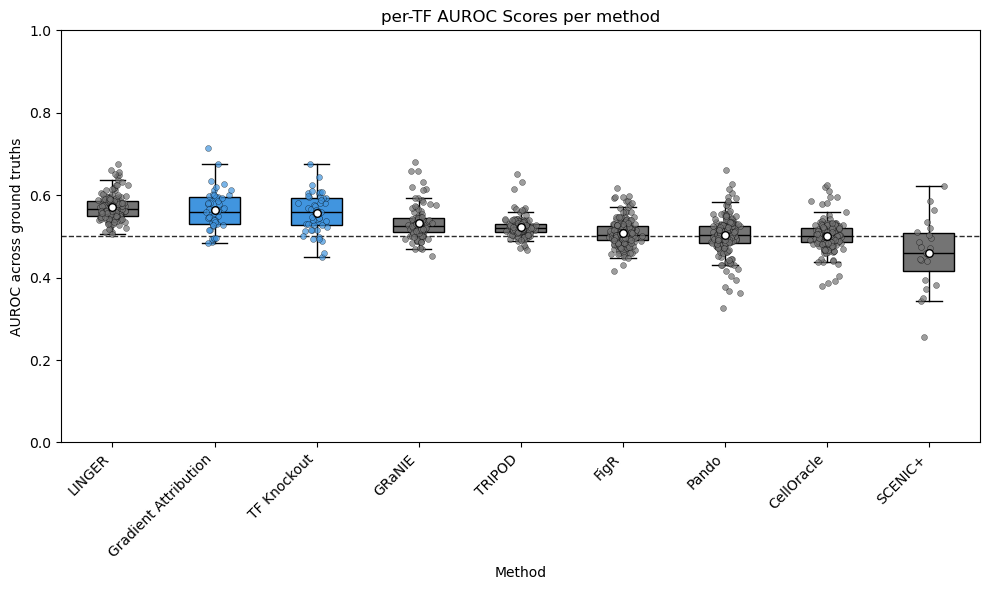

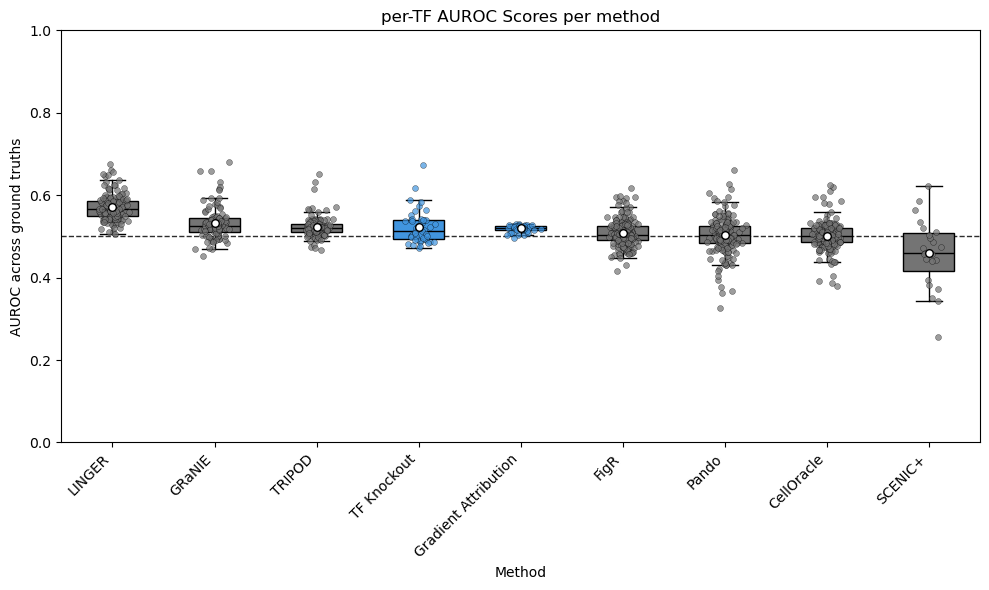

In [12]:
k562_per_tf_orig, k562_per_gt_orig = open_auc_data_files(k562_exp_name, model_num=1)
k562_per_tf_ref, k562_per_gt_ref = open_auc_data_files(k562_exp_name, model_num=2)

per_tf_method_three(k562_per_tf_orig)
per_tf_method_three(k562_per_tf_ref)

In [15]:
linger_mESC_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/raw/LINGER_mESC"

for sample_dir in Path(linger_mESC_dir).iterdir():
    if sample_dir.is_dir():
        print(f"Sample dir: {sample_dir.name}")
        for file in sample_dir.iterdir():
            if file.name.endswith("RE_pseudobulk.tsv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file, sep="\t", header=0, index_col=0)
                df.to_parquet(file.with_suffix(".parquet"), index=0)
                
            if file.name.endswith("TG_pseudobulk.tsv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file, sep="\t", header=0, index_col=0)
                df.to_parquet(file.with_suffix(".parquet"), index=0)

Sample dir: E8.0_rep2
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E7.5_rep1
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E8.75_rep1
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E8.75_rep2
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E8.5_rep1
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E8.5_CRISPR_T_KO
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E8.0_rep1
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E8.5_rep2
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E7.75_rep1
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv
Sample dir: E7.5_rep2
  - File: RE_pseudobulk.tsv
  - File: TG_pseudobulk.tsv


In [17]:
df = pd.read_parquet("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/processed/LINGER_mESC/E7.5_rep1/RE_pseudobulk.parquet")
df.head()

,E7.5_rep1#ATTGCACAGCTTGCTC-1,E7.5_rep1#CCCGCTTCACCTGCCT-1,E7.5_rep1#TATGGTCAGGACAATG-1,E7.5_rep1#GAGGTAGGTGGACCTG-1,E7.5_rep1#TCAATCGCACTGACCG-1,E7.5_rep1#GCAATCTAGGTGAGAC-1,E7.5_rep1#TGAGGCACATTATGAC-1,E7.5_rep1#TGTCAGTAGTCATGCG-1,E7.5_rep1#CCCGTAAAGCAAGATG-1,E7.5_rep1#CATCATGCATAGTCAT-1,...,E7.5_rep1#AGCTTGGTCATAGCCG-1,E7.5_rep1#GTTTGTTTCAATGAGG-1,E7.5_rep1#CGTTGCGCAATTTGGT-1,E7.5_rep1#TGTGGCCAGTTATCTC-1,E7.5_rep1#GAGCGATAGGTGAAGC-1,E7.5_rep1#CAAACCGTCTCACTAT-1,E7.5_rep1#GCCAGGAAGTTTGAGC-1,E7.5_rep1#GATCGCTCATAGACTT-1,E7.5_rep1#CCCAAACCAGCATGGA-1,E7.5_rep1#GGACCGAAGTGAACGA-1
chr1:3035602-3036202,0.000000,0.000000,0.057822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.057822,0.000000,0.000000,0.0,0.267768,0.057822,0.000000
chr1:3062653-3063253,0.000000,0.000000,0.000000,0.115643,0.000000,0.115643,0.000000,0.057822,0.000000,0.000000,...,0.0,0.115643,0.0,0.057822,0.000000,0.000000,0.0,0.115643,0.000000,0.057822
chr1:3072313-3072913,0.000000,0.000000,0.000000,0.000000,0.000000,0.057822,0.000000,0.000000,0.000000,0.000000,...,0.0,0.057822,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.231287
chr1:3191496-3192096,0.036481,0.036481,0.000000,0.057822,0.036481,0.057822,0.036481,0.225088,0.094303,0.094303,...,0.0,0.057822,0.0,0.000000,0.036481,0.167266,0.0,0.094303,0.000000,0.000000
chr1:3340575-3341175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.057822,0.000000,0.0,0.000000,0.000000,0.000000
